In [276]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime, date
from pathlib import Path
import json

from skimage import measure

import cartopy.crs as ccrs
import warnings

# for stereogrphic projection (converting lat-lon to physical distance (km))
from geopy.distance import geodesic

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    """
    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['longitude','latitude'])): # if coordinates set this way...
        data2 = data.rename({'latitude': 'lat'})
        data2 = data2.rename({'longitude': 'lon'})
    else:
        data2 = data

    # check if latitutde is decreasing
    if (data2.lat[1] - data2.lat[0]) < 0:
        data2 = data2.reindex(lat=list(reversed(data2.lat))) # flipping latitude accoordingly

    # check if longitude is -180 to 180
    # if so, reconstructing into 0 to 360
    if (data2.lon.min() < 0):
        data2['lon'] = xr.where(data2['lon'] < 0, data2['lon'] + 360, data2['lon'])
        data2 = data2.sortby('lon')

    return data2

In [4]:
pid_dir = Path('/scratch/wmtsai/GPM_feature_precip/2014/')
front_ori_dir = Path('/neelin2020/RGMA_feature_mask/data_product/2014/Front/')

In [5]:
ft_c_ori = xr.open_dataset(front_ori_dir / 'Front_cold_ERA5feature_mask_2014_01_6hrly.nc')
ft_c_ori = coordinates_processors(ft_c_ori)
ft_w_ori = xr.open_dataset(front_ori_dir / 'Front_warm_ERA5feature_mask_2014_01_6hrly.nc')
ft_w_ori = coordinates_processors(ft_w_ori)
ft_s_ori = xr.open_dataset(front_ori_dir / 'Front_stat_ERA5feature_mask_2014_01_6hrly.nc')
ft_s_ori = coordinates_processors(ft_s_ori)

In [6]:
# merge all tracks into a single xarray.dataset file 
ds_PFID = xr.open_dataset(pid_dir / 'GPM-IMERG_feature_precip_2014_01.nc')
feat_mask = xr.open_dataset(pid_dir / 'GPM_feature_merged_01_v4.nc')

In [7]:
PFID = ds_PFID.precip_id
ds_ARFTjoint = (PFID.where(PFID == 1, 0) + PFID.where(PFID == 2, 0) +
                PFID.where(PFID == 5, 0) + PFID.where(PFID == 11, 0) + PFID.where(PFID == 12, 0))

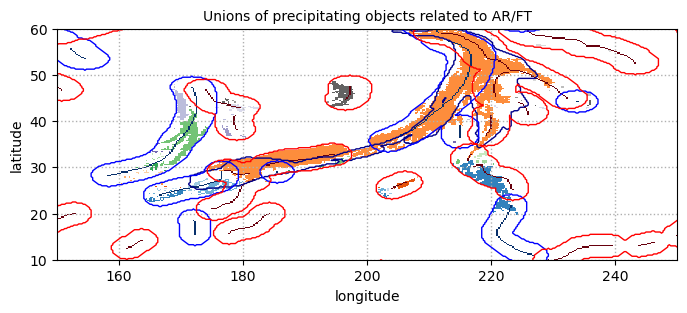

In [9]:
# background: unions of AR and FT
PFID = ds_PFID.isel(time=0).sel(latitude=slice(20,60),longitude=slice(160,240)).precip_id
ds_ARFTjoint = (PFID.where(PFID == 1, 0) + PFID.where(PFID == 2, 0) +
                PFID.where(PFID == 5, 0) + PFID.where(PFID == 11, 0) + PFID.where(PFID == 12, 0))
binary_ARFT = ds_ARFTjoint.where(ds_ARFTjoint == 0, 1)
# label precipitation features associated with the AR-FT union
(label, num) = measure.label(binary_ARFT.values, return_num=True, connectivity=2)

fig,ax = plt.subplots(1,1,figsize=(8,3))
cp = ax.pcolor(PFID.longitude, PFID.latitude, label, cmap='tab20c', vmin=1)
cp.cmap.set_under('w')
    
# add AR and expanded FT feature mask
ar_mask = feat_mask.isel(time=0).ar_tag
ft_c_mask = feat_mask.isel(time=0).front_c_tag
ft_w_mask = feat_mask.isel(time=0).front_w_tag
ft_s_mask = feat_mask.isel(time=0).front_s_tag
# add original FT feature mask
ft_c_orimask = ft_c_ori.isel(time=0).fronts
ft_c_orimask = ft_c_orimask.where(ft_c_orimask > 0)
ft_w_orimask = ft_w_ori.isel(time=0).fronts
ft_w_orimask = ft_w_orimask.where(ft_w_orimask > 0)
ft_s_orimask = ft_s_ori.isel(time=0).fronts
ft_s_orimask = ft_s_orimask.where(ft_s_orimask > 0)

# plot AR
ax.contour(ar_mask.longitude, ar_mask.latitude, ar_mask, levels=[0,1], colors=['darkblue'], linewidths=1)
# plot expanded FT
ax.contour(ft_c_mask.longitude, ft_c_mask.latitude, ft_c_mask, levels=[0,1], colors=['b'], linewidths=1)
ax.contour(ft_w_mask.longitude, ft_w_mask.latitude, ft_w_mask, levels=[0,1], colors=['r'], linewidths=1)
#ax.contour(ft_s_mask.longitude, ft_s_mask.latitude, ft_s_mask, levels=[0,1], colors=['g'], linewidths=1)
# plot original FT
ax.pcolormesh(ft_c_orimask.lon, ft_c_orimask.lat, ft_c_orimask, cmap='Blues_r')
ax.pcolormesh(ft_w_orimask.lon, ft_w_orimask.lat, ft_w_orimask, cmap='Reds_r')
#ax.pcolormesh(ft_s_orimask.lon, ft_s_orimask.lat, ft_s_orimask, cmap='Blues_r')
    
ax.set_ylabel('latitude',fontsize=10)
ax.set_xlabel('longitude',fontsize=10)
ax.set_title('Unions of precipitating objects related to AR/FT'.format(num), fontsize=10)
ax.grid(lw=1,ls=':')

ax.set_xlim([150,250])
ax.set_ylim([10,60])
plt.show()
fig.savefig('/scratch/wmtsai/featenv_analysis/fig/union_ARFT_example.pdf', bbox_inches='tight',
          transparent=False)

### implement scipy.binary_dilation 

In [95]:
os.chdir('/scratch/wmtsai/featenv_analysis/runscripts')
from feature_environment_module import *
from scipy.ndimage import binary_dilation, binary_erosion

In [11]:
def generate_dilation_featmask(ds_pf_binary, dilation_ngrids):

    ds_pf_binary_dilation = binary_dilation(ds_pf_binary, iterations=dilation_ngrids).astype('int')
    ds_dilation = xr.Dataset(data_vars=dict(pf_mask = (['lat','lon'], ds_pf_binary.values),
                                            env_mask = (['lat','lon'], ds_pf_binary_dilation-ds_pf_binary.values)),
                       coords=dict(lat = (['lat'], binary_ARFT.latitude.values),
                                   lon = (['lon'], binary_ARFT.longitude.values)),
                       attrs=dict(description='dilation of the AR-FT union binary mask',
                                  dilation_ngrids=dilation_ngrids))
    
    return ds_dilation

def generate_dilated_dataset(ds_dilation, var_input):
        
    # extract feat_mask and env_mask grid points
    (idx_lat, idx_lon) = np.where(ds_dilation.pf_mask + ds_dilation.env_mask == 1)
    ds_list = []
    for i,j in zip(idx_lat, idx_lon):
        ds_list.append(var_input.sel(lat=ds_dilation.lat[i], lon=ds_dilation.lon[j]))
    ds_array = np.asarray(ds_list)
        
    lat_1d = ds_dilation.lat.isel(lat=idx_lat).values
    lon_1d = ds_dilation.lon.isel(lon=idx_lon).values
    
    if len(ds_array.shape) == 1: # (ngrids)
        ds_dilation_1d = xr.Dataset(data_vars = dict(var_temp = (['ngrids'], ds_array),
                                                     lat = (['ngrids'], lat_1d),
                                                     lon = (['ngrids'], lon_1d)),
                                    coords = dict(ngrids = (['ngrids'], np.arange(len(idx_lat)))),
                                    attrs = dict(description = 'extracted grids of feature-environment',
                                                 lat_res = (ds_dilation.lat[1] - ds_dilation.lat[0]).values,
                                                 lon_res = (ds_dilation.lon[1] - ds_dilation.lon[0]).values)
                                   )
    elif len(ds_array.shape) == 2: # (ngrids, level)
        ds_dilation_1d = xr.Dataset(data_vars = dict(var_temp = (['ngrids','level'], ds_array),
                                                     lat = (['ngrids'], lat_1d),
                                                     lon = (['ngrids'], lon_1d)),
                                    coords = dict(ngrids = (['ngrids'], np.arange(len(idx_lat))),
                                                  level = (['level'], var_input.level.values)),
                                    attrs = dict(description = 'extracted grids of feature-environment',
                                                 lat_res = (ds_dilation.lat[1] - ds_dilation.lat[0]).values,
                                                 lon_res = (ds_dilation.lon[1] - ds_dilation.lon[0]).values,
                                                 p_level = len(var_input.level))
                                   )      
    # rename variable
    var_name = [i for i in var_input.to_dataset().keys()][0]
    ds_dilation_1d = ds_dilation_1d.rename_vars({'var_temp': var_name})
    
    return ds_dilation_1d

In [12]:
def reconstruct_geocoords(ds_dilation_1d):

    # converting ds_dilation_1d back to the lat-lon coordinate
    nan_boolen = np.isnan(ds_dilation_1d.pf_mask)
    if np.sum(nan_boolen) >= 1:
        idx_end = np.where(nan_boolen > 0)[0][0]-1  
        ds_dilation_1d = ds_dilation_1d.sel(ngrids=slice(0,idx_end)) # get full valid values by removing NaN 
    
    lat_min = np.nanmin(ds_dilation_1d.lat.values)
    lat_max = np.nanmax(ds_dilation_1d.lat.values)
    lon_min = np.nanmin(ds_dilation_1d.lon.values)
    lon_max = np.nanmax(ds_dilation_1d.lon.values)

    ds_reconst = []
    for var in ds_dilation_1d.keys():
        if (var != 'lon') and (var != 'lat'):
            lon_re = np.arange(lon_min, lon_max + ds_dilation_1d.attrs['lon_res'], ds_dilation_1d.attrs['lon_res'])
            lat_re = np.arange(lat_min, lat_max + ds_dilation_1d.attrs['lat_res'], ds_dilation_1d.attrs['lat_res'])

            ds_var = ds_dilation_1d[var]
            if len(ds_var.dims) == 1: # (ngrids)

                var_map = np.full((len(lat_re), len(lon_re)),np.nan)

                for i in range(len(ds_var.ngrids)): 
                    lon = ds_dilation_1d.isel(ngrids=i).lon.values
                    lat = ds_dilation_1d.isel(ngrids=i).lat.values
                    idx_lon = np.where(lon_re == lon)[0]
                    idx_lat = np.where(lat_re == lat)[0]
                    var_map[idx_lat, idx_lon] = ds_var.isel(ngrids=i)

                ds = xr.Dataset(data_vars=dict(var_temp=(['lat','lon'],var_map)),
                                coords=dict(lon=(['lon'],lon_re),
                                            lat=(['lat'],lat_re)))
                ds = ds.rename_vars({'var_temp': str(var)})

            elif len(ds_var.dims) == 2: # (ngrids, level)

                nlevel = ds_dilation_1d.attrs['p_level']
                var_map = np.full((len(lat_re), len(lon_re), nlevel),np.nan)

                for i in range(len(ds_var.ngrids)):                 
                    lon = ds_dilation_1d.isel(ngrids=i).lon.values
                    lat = ds_dilation_1d.isel(ngrids=i).lat.values
                    idx_lon = np.where(lon_re == lon)[0]
                    idx_lat = np.where(lat_re == lat)[0]
                    var_map[idx_lat, idx_lon, :] = ds_var.isel(ngrids=i)

                ds = xr.Dataset(data_vars=dict(var_temp=(['lat','lon','level'],var_map)),
                                coords=dict(lon=(['lon'],lon_re),
                                            lat=(['lat'],lat_re),
                                            level=(['level'],ds_dilation_1d.level.values)))
                ds = ds.rename_vars({'var_temp': str(var)})        

            ds_reconst.append(ds)
    # merge all variables in the dilation dataset for a single feature
    ds_reconst_xr = xr.merge(ds_reconst)
    
    return ds_reconst_xr

In [28]:
PFID = ds_PFID.isel(time=0).sel(latitude=slice(20,60),longitude=slice(160,240)).precip_id

# have some real varialbes saved
timestr = str(PFID.time.values)
year = int(timestr[:4])
month = int(timestr[5:7])
day = int(timestr[8:10])
hour = int(timestr[11:13])
timestamp = datetime(year,month,day,hour)

data = xr.open_dataset('/scratch/wmtsai/GPM_feature_precip/2014/GPM_feature_merged_01_v4.nc').sel(time=timestamp)
prec_gpm = data.precipitationCal
prec_gpm = coordinates_processors(prec_gpm).sel(lon=slice(0,359.75))
ar_tag = data.ar_tag
ar_tag = coordinates_processors(ar_tag).sel(lon=slice(0,359.75))
front_c_tag = data.front_c_tag
front_c_tag = coordinates_processors(front_c_tag).sel(lon=slice(0,359.75))
front_w_tag = data.front_w_tag
front_w_tag = coordinates_processors(front_w_tag).sel(lon=slice(0,359.75))
mcs_tag = data.mcs_tag
mcs_tag = coordinates_processors(front_mcs_tag).sel(lon=slice(0,359.75))

data = xr.open_dataset('/neelin2020/ERA-5/NC_FILES/2014/era-5.q.2014.01.nc').sel(time=timestamp)
q = data.q
q = coordinates_processors(q).sel(lat=slice(-60,60))
data = xr.open_dataset('/neelin2020/ERA-5/NC_FILES/2014/era-5.T.2014.01.nc').sel(time=timestamp)
T = data.t
T = coordinates_processors(T).sel(lat=slice(-60,60))
data = xr.open_dataset('/neelin2020/ERA-5/NC_FILES/2014/era-5.q.2014.01.nc').sel(time=timestamp)
q = data.q
q = coordinates_processors(q).sel(lat=slice(-60,60))

# define precipitation features associated with the AR-FT union 
ds_ARFTjoint = (PFID.where(PFID == 1, 0) + PFID.where(PFID == 2, 0) +
                PFID.where(PFID == 5, 0) + PFID.where(PFID == 11, 0) + PFID.where(PFID == 12, 0))
binary_ARFT = ds_ARFTjoint.where(ds_ARFTjoint == 0, 1)

# label precipitation features associated with the AR-FT union
(label, num) = measure.label(binary_ARFT.values, return_num=True, connectivity=2)
ds_pf = xr.Dataset(data_vars=dict(p_feat = (['lat','lon'], label)),
                   coords=dict(latitude = (['lat'], binary_ARFT.latitude.values),
                               longitude = (['lon'], binary_ARFT.longitude.values)),
                   attrs=dict(description='precpitatio of the AR-FT union binary mask'))
ds_pf['p_feat'] = ds_pf['p_feat'].where(ds_pf['p_feat'] > 0)

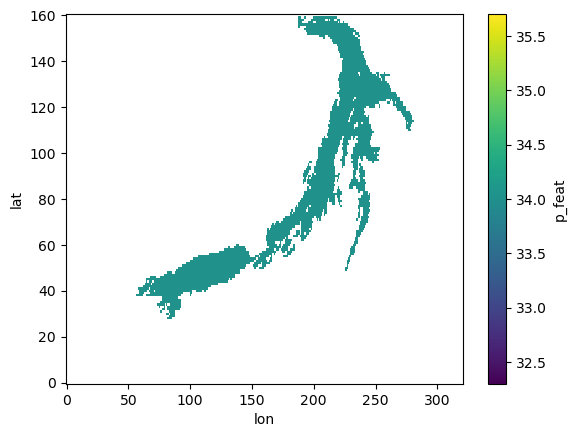

In [14]:
ds_pf['p_feat'].where(ds_pf['p_feat'] == 34).plot()

In [15]:
# ds_pf_binary = ds_pf['p_feat'].where(ds_pf['p_feat'] == 34, 0)
# ds_pf_binary = ds_pf_binary.where(ds_pf_binary == 0, 1)
# test = binary_dilation(ds_pf_binary, iterations=1).astype('int')

In [71]:
%%time
# get dilation dataset (object_id, ngrids, level)

num_list = np.arange(34,50)

ds_dilation_object = []
for num_sel in num_list:
    
    ds_pf_binary = ds_pf['p_feat'].where(ds_pf['p_feat'] == num_sel, 0)
    ds_pf_binary = ds_pf_binary.where(ds_pf_binary == 0, 1)
    
    if np.sum(ds_pf_binary) >= 40:
        print('processing precipitation feature number: {}'.format(num_sel))

        ds_dilation = generate_dilation_featmask(ds_pf_binary, dilation_ngrids=15)
        ds_dilation_1d = generate_dilated_dataset(ds_dilation, ds_dilation.pf_mask)
        ds_dilation_prec = generate_dilated_dataset(ds_dilation, prec_gpm)

        ds_dilation_ar = generate_dilated_dataset(ds_dilation, ar_tag)
        ds_dilation_ft_c = generate_dilated_dataset(ds_dilation, front_c_tag)
        ds_dilation_ft_w = generate_dilated_dataset(ds_dilation, front_w_tag)
        ds_dilation_mcs = generate_dilated_dataset(ds_dilation, mcs_tag)

        ds_dilation_q = generate_dilated_dataset(ds_dilation, q)
        ds_dilation_merged = xr.merge([ds_dilation_1d, ds_dilation_prec, ds_dilation_q,
                                      ds_dilation_ar, ds_dilation_ft_c, ds_dilation_ft_w,
                                      ds_dilation_mcs], combine_attrs='no_conflicts')

        ds_dilation_object.append(ds_dilation_merged)
    
ds_dilation_object_xr = xr.concat(ds_dilation_object, dim=pd.Index(np.arange(len(ds_dilation_object)), name='samples'), combine_attrs='no_conflicts')

CPU times: user 9.64 ms, sys: 1.96 ms, total: 11.6 ms
Wall time: 10.7 ms


In [210]:
# transform into lat-lon coords
ds_reconst_xr = reconstruct_geocoords(ds_dilation_object_xr.isel(samples=0))
ds_reconst_xr['cwv'] = (100/9.8*ds_reconst_xr.q.integrate('level'))

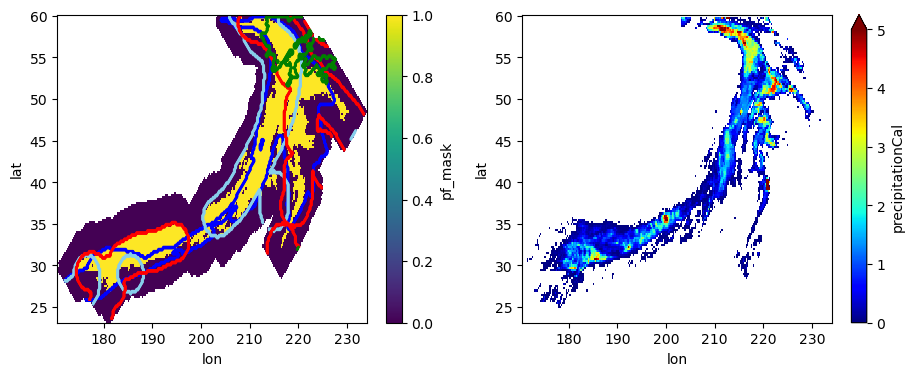

In [211]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,4))
ds_reconst_xr.pf_mask.plot(ax=ax1)
ds_reconst_xr.ar_tag.plot.contour(ax=ax1, colors=['b'])
ds_reconst_xr.front_c_tag.plot.contour(ax=ax1, colors=['skyblue'])
ds_reconst_xr.front_w_tag.plot.contour(ax=ax1, colors=['r'])
ds_reconst_xr.mcs_tag.plot.contour(ax=ax1, colors=['g'])

precip = ds_reconst_xr.precipitationCal.copy()
precip = precip.where(precip > 0)
precip.plot(ax=ax2, vmin=0, vmax=5, cmap='jet')

plt.show()

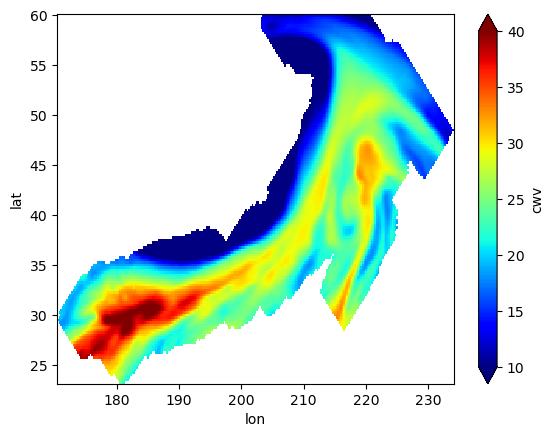

In [212]:
ds_reconst_xr.cwv.plot(vmin=10, vmax=40, cmap='jet')

In [235]:
# composite mean of variables as a function of grid in the radiant direction

pf_mask = ds_reconst_xr.pf_mask
pf_mask = pf_mask.where(pf_mask > 0, 0)

compos_vars_outside = []
for dilation_ngrids in np.arange(1,16):

    temp1 = binary_dilation(pf_mask, iterations=dilation_ngrids).astype('int')
    if dilation_ngrids == 1:
        temp2 = pf_mask.values
    else:
        temp2 = binary_erosion(pf_mask, iterations=dilation_ngrids-1).astype('int')
    boundary = temp1 - temp2
    boundary_xr = (pf_mask*0 + boundary).rename('boundary')
    # use boundary_xr as mask for composite of vars. outside the precip. feature
    vars_bound = ds_reconst_xr.where(boundary_xr == 1)
    compos_vars_outside.append(vars_bound.mean(('lat','lon')))

ds_composite_out = xr.concat(compos_vars_outside, pd.Index(np.flip(np.arange(-len(compos_vars_outside),0,1))
                                                               , name='grid_to_boundary'))

compos_vars_inside = []
for dilation_ngrids in np.arange(1,16):

    temp1 = binary_erosion(pf_mask, iterations=dilation_ngrids).astype('int')
    if dilation_ngrids == 1:
        temp2 = pf_mask.values
    else:
        temp2 = binary_erosion(pf_mask, iterations=dilation_ngrids-1).astype('int')
    boundary = temp2 - temp1
    boundary_xr = (pf_mask*0 + boundary).rename('boundary')
    # use boundary_xr as mask for composite of vars. outside the precip. feature
    vars_bound = ds_reconst_xr.where(boundary_xr == 1)
    if np.sum(boundary) > 0:
        compos_vars_inside.append(vars_bound.mean(('lat','lon')))

ds_composite_in = xr.concat(compos_vars_inside, pd.Index(np.arange(len(compos_vars_inside))
                                                               , name='grid_to_boundary'))

# merge two sections together and sortby the relative position to the boundary of the precip. feature
ds_composite_merged = xr.concat([ds_composite_out, ds_composite_in], dim='grid_to_boundary').sortby('grid_to_boundary')

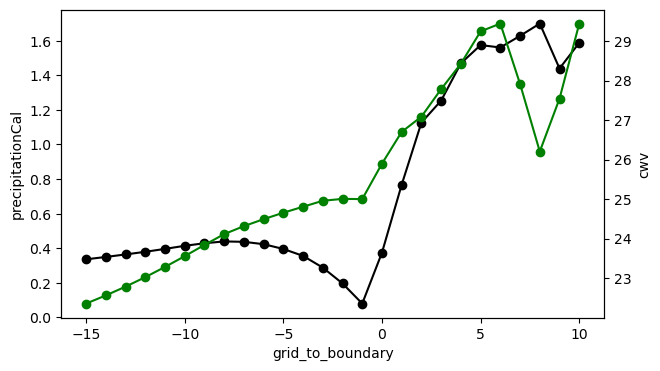

In [237]:
fig, ax = plt.subplots(1,1,figsize=(7,4))
ds_composite_merged.precipitationCal.plot(ax=ax,ls='-',marker='o',color='k')
ax2 = ax.twinx()
ds_composite_merged.cwv.plot(ax=ax2,ls='-',marker='o',color='g')

#### test: getting corresponding PFID by feature names

In [267]:
os.chdir('/scratch/wmtsai/featenv_analysis/config/config_pid_env')

# read feature and variable settings from .json files
feature_json = open('feature_list_default.jsonc')
variable_json = open('varible_list.default.jsonc')
feature_settings = json.load(feature_json)
variable_settings = json.load(variable_json)

In [253]:
ds_PFID

<xarray.Dataset> Size: 86MB
Dimensions:    (time: 124, longitude: 1440, latitude: 481)
Coordinates:
  * time       (time) datetime64[ns] 992B 2014-01-01 ... 2014-01-31T18:00:00
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float64 4kB -60.0 -59.75 -59.5 ... 59.5 59.75 60.0
Data variables:
    precip_id  (time, latitude, longitude) int8 86MB 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    description:             \n         This data provides 0.25-deg, 6-hourly...
    feauture_algorithms:     AR: TECA-BARD; FT: Sansom and Catto (2022); MCS:...
    convection_definitions:  Deep convection (T$_{b}$ <= 250K, P > 0.5 mm/hr)...
    defined_parameters:      CC-threshold: 250K in the tropics (30N-30S) and ...
    version:                 RGMA global feature-precipitation identifiers. v1.0
    contact:                 Wei-Ming Tsai (wmtsai@g.ucla.edu), University of...

In [269]:
PFID_catalog = {'AR':1, 'FT':2, 'MCS': 3, 'LPS': 4, 
             'AR-FT': 5, 'AR-MCS': 6, 'AR-LPS': 7,
             'Front-MCS': 8,' Front-LPS': 9, 'MCS-LPS': 10,
             'AR-Front-MCS': 11, 'AR-Front-LPS': 12, 'AR-MCS-LPS': 13,
             'Front-MCS-LPS': 14, 'AR-Front-MCS-LPS': 15, 
             'Unexp': 16,
             'DC': 17, 'ND': 18, 'ST': 19, 'DZ': 20}

In [271]:
PFID_select = feature_settings['PFID'][0]['feature_comb']
PFID_number = PFID_catalog[PFID_select]
print(PFID_select, PFID_number)

AR-FT 5


In [273]:
feature_settings['PFID'][0]['month']

'01'

In [ ]:
origin = (30.172705, 31.526725)  # (latitude, longitude) 
dist = (30.288281, 31.732326)

print(geodesic(origin, dist).meters)  # 23576.805481751613
print(geodesic(origin, dist).kilometers)  # 23.576805481751613
print(geodesic(origin, dist).miles)  # 14.64994773134371

In [331]:
test = xr.open_dataset('/scratch/wmtsai/featenv_analysis/dataset/test/ds_dilation_test.nc')
test_reconst_xr = reconstruct_geocoords(test.isel(samples=1))

In [330]:
size = []
for i in range(len(test.samples)):
    tmp = test.isel(samples=i).pf_mask.values
    size.append(np.nansum(tmp).astype('int'))
size

[301,
 2625,
 1073,
 1213,
 66,
 29,
 270,
 30,
 142,
 1971,
 28,
 372,
 29,
 31,
 156,
 33,
 336,
 380,
 534,
 140,
 41,
 77,
 535,
 2630,
 218,
 1819,
 643,
 25,
 115]

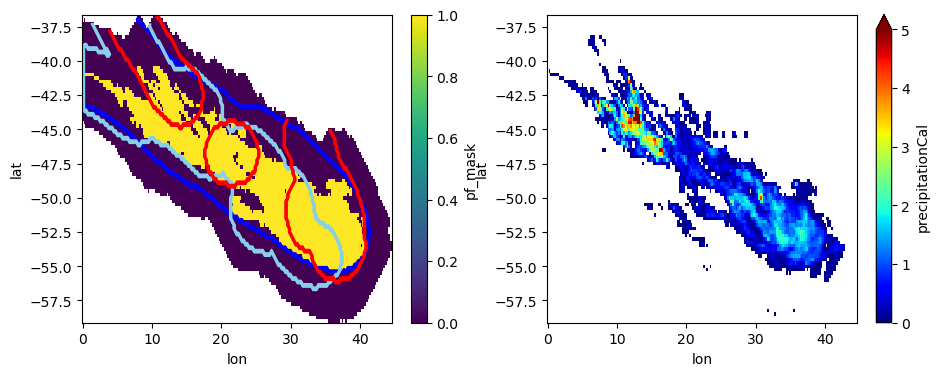

In [332]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,4))
test_reconst_xr.pf_mask.plot(ax=ax1)
test_reconst_xr.ar_tag.plot.contour(ax=ax1, colors=['b'])
test_reconst_xr.front_c_tag.plot.contour(ax=ax1, colors=['skyblue'])
test_reconst_xr.front_w_tag.plot.contour(ax=ax1, colors=['r'])
test_reconst_xr.mcs_tag.plot.contour(ax=ax1, colors=['g'])

precip = test_reconst_xr.precipitationCal.copy()
precip = precip.where(precip > 0)
precip.plot(ax=ax2, vmin=0, vmax=5, cmap='jet')

plt.show()

In [333]:
# composite mean of variables as a function of grid in the radiant direction

pf_mask = test_reconst_xr.pf_mask
pf_mask = pf_mask.where(pf_mask > 0, 0)

compos_vars_outside = []
for dilation_ngrids in np.arange(1,16):
    
    temp1 = binary_dilation(pf_mask, iterations=dilation_ngrids).astype('int')
    if dilation_ngrids == 1:
        temp2 = pf_mask.values
    else:
        temp2 = binary_erosion(pf_mask, iterations=dilation_ngrids-1).astype('int')
    boundary = temp1 - temp2
    boundary_xr = (pf_mask*0 + boundary).rename('boundary')
    # use boundary_xr as mask for composite of vars. outside the precip. feature
    vars_bound = test_reconst_xr.where(boundary_xr == 1)
    compos_vars_outside.append(vars_bound.mean(('lat','lon')))

ds_composite_out = xr.concat(compos_vars_outside, pd.Index(np.flip(np.arange(-len(compos_vars_outside),0,1))
                                                               , name='grid_to_boundary'))

compos_vars_inside = []
for dilation_ngrids in np.arange(1,16):
    
    temp1 = binary_erosion(pf_mask, iterations=dilation_ngrids).astype('int')
    if dilation_ngrids == 1:
        temp2 = pf_mask.values
    else:
        temp2 = binary_erosion(pf_mask, iterations=dilation_ngrids-1).astype('int')
    boundary = temp2 - temp1
    boundary_xr = (pf_mask*0 + boundary).rename('boundary')
    # use boundary_xr as mask for composite of vars. outside the precip. feature
    vars_bound = test_reconst_xr.where(boundary_xr == 1)
    if np.sum(boundary) > 0:
        compos_vars_inside.append(vars_bound.mean(('lat','lon')))

ds_composite_in = xr.concat(compos_vars_inside, pd.Index(np.arange(len(compos_vars_inside))
                                                               , name='grid_to_boundary'))

# merge two sections together and sortby the relative position to the boundary of the precip. feature
ds_composite_merged = xr.concat([ds_composite_out, ds_composite_in], dim='grid_to_boundary').sortby('grid_to_boundary')

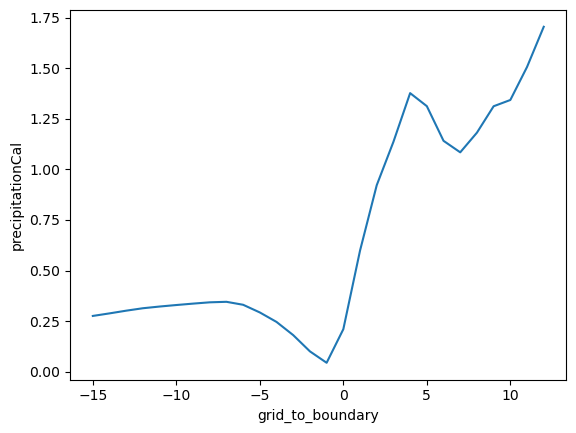

In [334]:
ds_composite_merged.precipitationCal.plot()

In [335]:
test = xr.open_dataset('/scratch/wmtsai/featenv_analysis/dataset/test/envs_composite_test.nc')
test

<xarray.Dataset> Size: 23kB
Dimensions:           (samples: 3, grid_to_boundary: 28, level: 27)
Coordinates:
  * level             (level) int32 108B 100 125 150 175 ... 925 950 975 1000
  * grid_to_boundary  (grid_to_boundary) int64 224B -15 -14 -13 -12 ... 10 11 12
  * samples           (samples) int64 24B 0 1 2
Data variables:
    pf_mask           (samples, grid_to_boundary) float64 672B ...
    precipitationCal  (samples, grid_to_boundary) float64 672B ...
    q                 (samples, grid_to_boundary, level) float64 18kB ...
    ar_tag            (samples, grid_to_boundary) float64 672B ...
    front_c_tag       (samples, grid_to_boundary) float64 672B ...
    front_w_tag       (samples, grid_to_boundary) float64 672B ...
    mcs_tag           (samples, grid_to_boundary) float64 672B ...

(1000.0, 100.0)

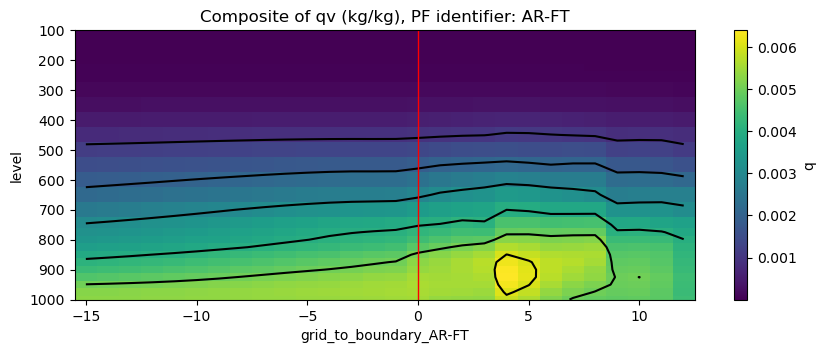

In [350]:
fig, ax = plt.subplots(figsize=(10,3.5))
test.q.mean('samples').plot(ax=ax, x='grid_to_boundary',y='level')
test.q.mean('samples').plot.contour(ax=ax, x='grid_to_boundary'
                                    ,y='level',zorder=2, levels=np.arange(0.001,0.007,0.001), colors=['k'])
ax.vlines(x=0,ymin=100,ymax=1000,color='r',lw=1)
ax.set_xlabel('grid_to_boundary_AR-FT')
ax.set_title('Composite of qv (kg/kg), PF identifier: AR-FT')
plt.ylim([1000,100])

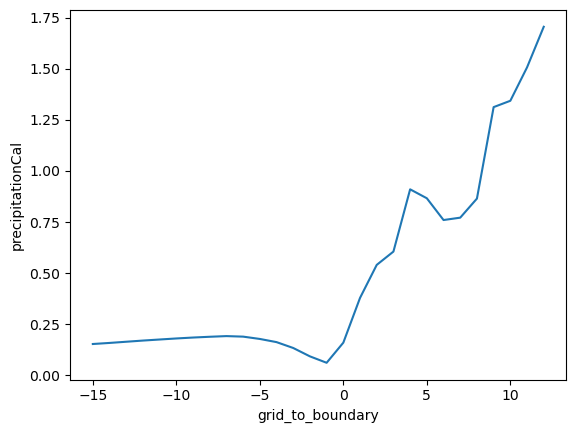

In [345]:
test.precipitationCal.mean('samples').plot(x='grid_to_boundary')

In [359]:
# read config jsonc file from ../config
os.chdir('/scratch/wmtsai/featenv_analysis/config/config_pid_env')
feature_json = open('feature_list_default.jsonc')
variable_json = open('varible_list.default.jsonc')
feature_settings = json.load(feature_json)
variable_settings = json.load(variable_json)

In [361]:
variable_settings

{'variable_inputs': [{'var_name': 'T',
   'varname_infile': 't',
   'specified_level': 'None',
   'format_saved': 'monthly',
   'freqency': 'hourly',
   'var_dir': '/neelin2020/ERA-5/NC_FILES/',
   'file_str': 'era-5.X.YYYY.MM.nc'},
  {'var_name': 'q',
   'varname_infile': 'q',
   'specified_level': 'None',
   'format_saved': 'monthly',
   'freqency': 'hourly',
   'var_dir': '/neelin2020/ERA-5/NC_FILES/',
   'file_str': 'era-5.X.YYYY.MM.nc'},
  {'var_name': 'w',
   'varname_infile': 'omega',
   'specified_level': 'None',
   'format_saved': 'monthly',
   'freqency': 'hourly',
   'var_dir': '/neelin2020/ERA-5/NC_FILES/',
   'file_str': 'era-5.X.YYYY.MM.nc'},
  {'var_name': '2t',
   'varname_infile': 'VAR_2T',
   'format_saved': 'monthly',
   'freqency': 'hourly',
   'var_dir': '/neelin2020/ERA-5/NC_FILES/',
   'file_str': 'era-5.X.YYYY.MM.nc'},
  {'var_name': '2d',
   'varname_infile': 'VAR_2D',
   'format_saved': 'monthly',
   'freqency': 'hourly',
   'var_dir': '/neelin2020/ERA-5/NC_FI

In [360]:
for i in range(len(variable_settings['variable_inputs'])):
    
    var_dict = variable_settings['variable_inputs'][i]
    print(var_dict['var_name'], var_dict['var_dir'], var_dict['file_str'])

T /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
q /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
w /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
2t /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
2d /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
sp /neelin2020/ERA-5/NC_FILES/ era-5.X.YYYY.MM.nc
precipitation /neelin2020/mcs_flextrkr/ mcstrack_YYYYMMDD_HH30.nc
tb /neelin2020/mcs_flextrkr/ mcstrack_YYYYMMDD_HH30.nc
